# 2025 CVE Time Series Forecasting using Kalman Filter

Backgound on the Kalman Filter:
https://en.wikipedia.org/wiki/Kalman_filter 

Python Library Used: 
https://unit8co.github.io/darts/

In [24]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import KalmanForecaster

In [25]:
import glob
import json
import pandas as pd
import numpy as np
from datetime import date

def get_nested_value(entry, keys, default='Missing_Data'):
    try:
        for key in keys:
            entry = entry[key]
        return entry
    except (KeyError, IndexError):
        return default

row_accumulator = []
for filename in glob.glob('nvd.jsonl'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data:
            new_row = {
                'CVE': get_nested_value(entry, ['cve', 'id']),
                'Published': get_nested_value(entry, ['cve', 'published']),
                'AttackVector': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackVector']),
                'AttackComplexity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'attackComplexity']),
                'PrivilegesRequired': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'privilegesRequired']),
                'UserInteraction': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'userInteraction']),
                'Scope': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'scope']),
                'ConfidentialityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'confidentialityImpact']),
                'IntegrityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'integrityImpact']),
                'AvailabilityImpact': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'availabilityImpact']),
                'BaseScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseScore'], '0.0'),
                'BaseSeverity': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'cvssData', 'baseSeverity']),
                'ExploitabilityScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'exploitabilityScore']),
                'ImpactScore': get_nested_value(entry, ['cve', 'metrics', 'cvssMetricV31', 0, 'impactScore']),
                'CWE': get_nested_value(entry, ['cve', 'weaknesses', 0, 'description', 0, 'value']),
                'Description': get_nested_value(entry, ['cve', 'descriptions', 0, 'value'], ''),
                'Assigner': get_nested_value(entry, ['cve', 'sourceIdentifier']),
                'Tag': get_nested_value(entry, ['cve', 'cveTags', 0, 'tags'], np.nan),
                'Status': get_nested_value(entry, ['cve', 'vulnStatus'], '')
            }
            row_accumulator.append(new_row)

nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.nan);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
pastdata = ((nvd['Published'] > '2017-01-01') & (nvd['Published']  < '2025-01-01'))
thisyear = ((nvd['Published'] > '2025-01-01') & (nvd['Published']  < '2026-01-01'))
nvd_2024 = nvd.loc[thisyear]
nvd = nvd.loc[pastdata]
startdate = date(2017, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [26]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **179728**<br />Average CVEs Per Day: **66.07**<br />Average CVSS Score: **6.91**

In [27]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Published'] = nvd['Published'].dt.to_period('M').dt.to_timestamp()  # Normalize to start of the month
monthly = nvd['Published'].groupby(nvd.Published).agg('count')
monthly_cves = pd.DataFrame(monthly)
monthly_cves.columns = ['Count']
monthly_cves = monthly_cves .reset_index()
monthly_cves = monthly_cves.rename(columns={"Published" : "Month" ,"Count": "CVEs"})
monthly_cves['Month'] = monthly_cves['Month'].astype(str)
monthly_cves['Month'] = pd.to_datetime(monthly_cves['Month'])

<Axes: xlabel='Month'>

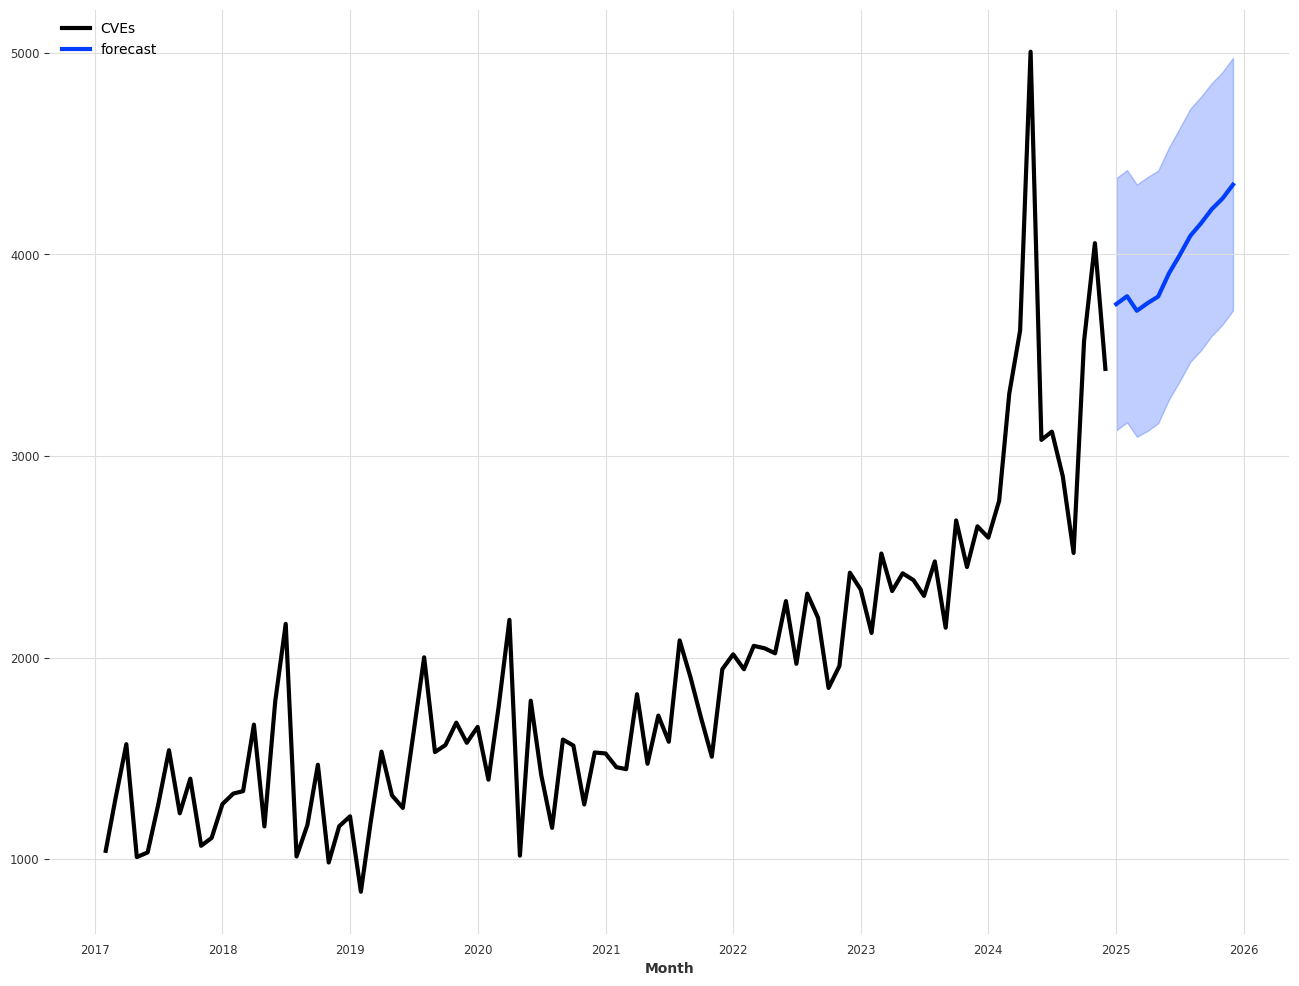

In [28]:
train = TimeSeries.from_dataframe(monthly_cves,"Month", "CVEs")
model = KalmanForecaster(dim_x=4)
model.fit(train)
pred = model.predict(n=12, num_samples=100000)

plt.figure(figsize=(16,12))
train.plot(lw=3)
pred.plot(lw=3, label='forecast')

In [37]:
darts_df = pred.to_dataframe()  # Updated method
darts_monthly = pred.to_dataframe().mean(axis=1).round(0)  # Updated method
darts_monthly = darts_monthly.to_frame()
darts_monthly = darts_monthly.reset_index()
darts_monthly = darts_monthly.rename(columns={0: "CVEs Predicted"})
darts_monthly['Month'] = darts_monthly['Month'].dt.month_name()
darts_monthly

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Month,CVEs Predicted
0,January,3754.0
1,February,3793.0
2,March,3721.0
3,April,3757.0
4,May,3792.0
5,June,3907.0
6,July,3996.0
7,August,4093.0
8,September,4157.0
9,October,4224.0


In [30]:
darts_monthly['CVEs Predicted'].sum()

47819.0

In [31]:
monthly_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
monthly_cves_2024 = pd.DataFrame(monthly_2024)
monthly_cves_2024.columns = ['Count']
monthly_cves_2024 = monthly_cves_2024.reset_index()
monthly_cves_2024 = monthly_cves_2024.rename(columns={"Published" : "Month" ,"Count": "CVEs Actual"})
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].astype(str)
monthly_cves_2024['Month'] = pd.to_datetime(monthly_cves_2024['Month'])
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].dt.month_name()
monthly_cves_2024

,Month,CVEs Actual
0,February,3681
1,March,3527


In [32]:
validation_df = pd.merge(
    monthly_cves_2024,
    darts_monthly,
    how="outer",
    on='Month',
)

month_categories = ['January', 'February', 'March', 'April', 'May', 'June', 
                    'July', 'August', 'September', 'October', 'November', 'December', 'Total']

validation_df['Month'] = pd.Categorical(validation_df['Month'], categories = month_categories, ordered = True)
validation_df = validation_df.sort_values(by='Month')


validation_df

,Month,CVEs Actual,CVEs Predicted
4,January,NaN,3754.0
3,February,3681.0,3793.0
7,March,3527.0,3721.0
0,April,NaN,3757.0
8,May,NaN,3792.0
6,June,NaN,3907.0
5,July,NaN,3996.0
1,August,NaN,4093.0
11,September,NaN,4157.0
10,October,NaN,4224.0


In [33]:
validation_df = validation_df[['Month', 'CVEs Predicted', 'CVEs Actual']]
validation_df['Difference'] = validation_df['CVEs Actual'] -  validation_df['CVEs Predicted'] 

numeric_df = validation_df.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)

validation_df = pd.concat([validation_df, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)
validation_df['CVEs Actual'].fillna(0, inplace=True)
validation_df['Difference'].fillna(0, inplace=True)


/var/folders/gw/2xvxmj6d6qn7h4x_jvkps1w00000gn/T/ipykernel_15679/3939809236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df['Difference'] = validation_df['CVEs Actual'] -  validation_df['CVEs Predicted']
/var/folders/gw/2xvxmj6d6qn7h4x_jvkps1w00000gn/T/ipykernel_15679/3939809236.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead,

In [34]:

def percentage_change(col1,col2):
    return ((col2 / col1) * 100).round(0)

validation_df['Precentage'] = percentage_change(validation_df['CVEs Predicted'],validation_df['CVEs Actual'])   

validation_df['Precentage'].fillna(0, inplace=True)
validation_df.at[12,'Month']='Total'



/var/folders/gw/2xvxmj6d6qn7h4x_jvkps1w00000gn/T/ipykernel_15679/3341750467.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validation_df['Precentage'].fillna(0, inplace=True)


In [35]:
darts_total = darts_monthly.copy()

darts_total.fillna(0) 
numeric_df = darts_total.select_dtypes(include=np.number)
total_row = numeric_df.sum(numeric_only=True)
darts_total = pd.concat([darts_total, pd.DataFrame(total_row.rename('Total')).T], ignore_index=True)

darts_total.at[12,'Month']='Total'
darts_total

,Month,CVEs Predicted
0,January,3754.0
1,February,3793.0
2,March,3721.0
3,April,3757.0
4,May,3792.0
5,June,3907.0
6,July,3996.0
7,August,4093.0
8,September,4157.0
9,October,4224.0


In [36]:
validation_df['CVEs Actual'].fillna(0, inplace=True)
validation_df['Difference'].fillna(0, inplace=True)
validation_df['Precentage'].fillna(0, inplace=True)
validation_df

/var/folders/gw/2xvxmj6d6qn7h4x_jvkps1w00000gn/T/ipykernel_15679/737123837.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  validation_df['CVEs Actual'].fillna(0, inplace=True)
/var/folders/gw/2xvxmj6d6qn7h4x_jvkps1w00000gn/T/ipykernel_15679/737123837.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

,Month,CVEs Predicted,CVEs Actual,Difference,Precentage
0,January,3754.0,0.0,0.0,0.0
1,February,3793.0,3681.0,-112.0,97.0
2,March,3721.0,3527.0,-194.0,95.0
3,April,3757.0,0.0,0.0,0.0
4,May,3792.0,0.0,0.0,0.0
5,June,3907.0,0.0,0.0,0.0
6,July,3996.0,0.0,0.0,0.0
7,August,4093.0,0.0,0.0,0.0
8,September,4157.0,0.0,0.0,0.0
9,October,4224.0,0.0,0.0,0.0
